In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize']=(6,6)
#plt.rcParams['font.weight']='bold'
#plt.rcParams['axes.labelweight']='bold'
#plt.rcParams['lines.linewidth']=1.5
#plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh, gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

def place_points(npoints, arc):
    arclength = np.zeros(np.size(arc[:,0]))
    for i,point in enumerate(arc):
        if i==0:
            arclength[i] = 0
        else:

            arclength[i] = arclength[i-1] + ((arc[i,0]-arc[i-1,0])**2+(arc[i,1]-arc[i-1,1])**2)**0.5

    spacing = arclength[-1]/npoints
    curr = 1
    inds = [0]
    locs = [arc[0,:]]
    for i, point in enumerate(arc):
        if(arclength[i]>curr*spacing and curr<npoints):
            inds.append(i)
            locs.append(arc[i])
            curr+=1
    return np.array(inds), np.array(locs)

In [3]:
r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/1.02, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.01)

In [4]:
plasma_dx = 0.02
coil_dx = 0.04
vv_dx = 0.01
vac_dx = 0.075

import json
with open('nsf_geom_new.json','r') as fid:
    nsf_geom = json.load(fid)

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
    # Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
gs_mesh.define_region('vv',vv_dx,'conductor',eta=8.6E-7)

    # Define each of the PF coils
gs_mesh.define_region('CS_1',coil_dx,'coil')
gs_mesh.define_region('CS_2',coil_dx,'coil')
gs_mesh.define_region('CS_3',coil_dx,'coil')

gs_mesh.define_region('PF_1U',coil_dx,'coil')
gs_mesh.define_region('PF_1L',coil_dx,'coil')
gs_mesh.define_region('PF_2U',coil_dx,'coil')
gs_mesh.define_region('PF_2L',coil_dx,'coil')
gs_mesh.define_region('PF_3U',coil_dx,'coil')
gs_mesh.define_region('PF_3L',coil_dx,'coil')
gs_mesh.define_region('PF_4U',coil_dx,'coil')
gs_mesh.define_region('PF_4L',coil_dx,'coil')

gs_mesh.define_region('plate_upper_inner',vv_dx,'conductor',eta=3.8E-8)
gs_mesh.define_region('plate_lower_inner',vv_dx,'conductor',eta=3.8E-8)
gs_mesh.define_region('plate_upper_outer',vv_dx,'conductor',eta=3.8E-8)
gs_mesh.define_region('plate_lower_outer',vv_dx,'conductor',eta=3.8E-8)

In [6]:
gs_mesh.add_annulus(lim2, 'plasma', vv2, 'vv', parent_name = 'air')

# Define each of the PF coils
gs_mesh.add_rectangle(0.599917, -0.57, 0.0749228, 0.36,'CS_1',parent_name = 'air')
gs_mesh.add_rectangle(0.599917, 0, 0.0749228, 0.72,'CS_2',parent_name = 'air')
gs_mesh.add_rectangle(0.599917, 0.57, 0.0749228, 0.36,'CS_3',parent_name = 'air')

gs_mesh.add_polygon(np.array(nsf_geom['PF1U'])/1000,'PF_1U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF1L'])/1000,'PF_1L',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF2U'])/1000, 'PF_2U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF2L'])/1000, 'PF_2L',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF3U'])/1000, 'PF_3U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF3L'])/1000, 'PF_3L',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF4U'])/1000, 'PF_4U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF4L'])/1000,'PF_4L',parent_name = 'air')

gs_mesh.add_polygon(np.array(nsf_geom['in_upper_plate'])/1000, 'plate_upper_inner', parent_name = 'plasma')
gs_mesh.add_polygon(np.array(nsf_geom['in_lower_plate'])/1000, 'plate_lower_inner', parent_name = 'plasma')
gs_mesh.add_polygon(np.array(nsf_geom['out_upper_plate'])/1000, 'plate_upper_outer', parent_name = 'plasma')
gs_mesh.add_polygon(np.array(nsf_geom['out_lower_plate'])/1000, 'plate_lower_outer', parent_name = 'plasma')

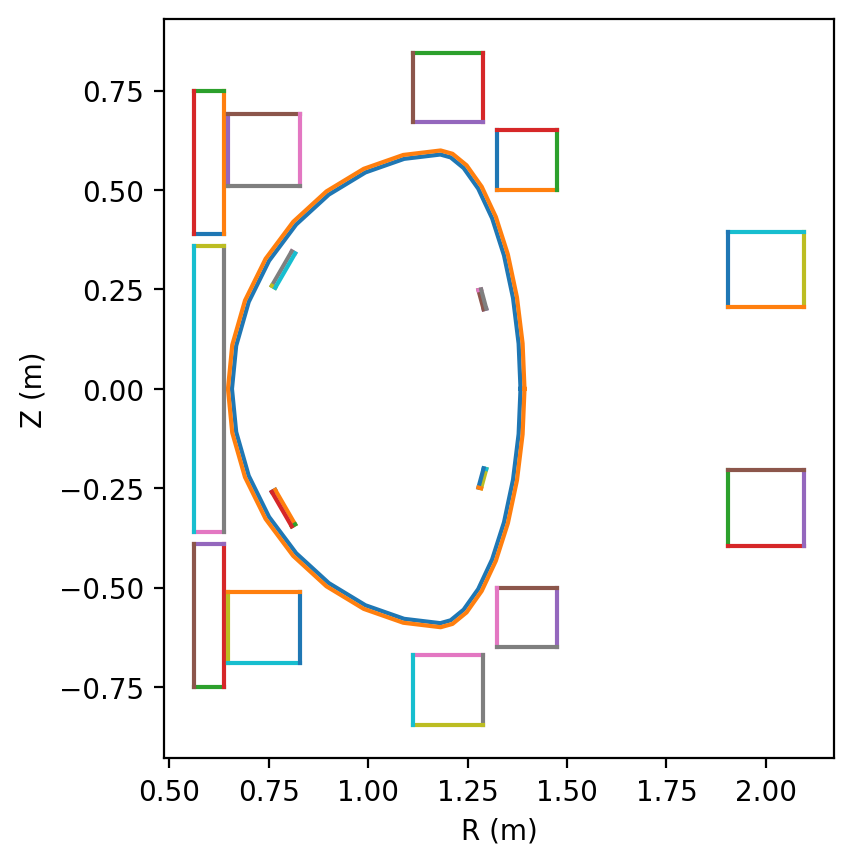

In [7]:
fig, ax = plt.subplots()
gs_mesh.plot_topology(fig,ax)

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 999
  # of unique segments  = 66
Generating mesh:
  # of points  = 5146
  # of cells   = 10170
  # of regions = 18


In [9]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.098E+00
    # of points  =    5146
    # of edges   =   15315
    # of cells   =   10170
    # of boundary points =     120
    # of boundary edges  =     120
    # of boundary cells  =     120
  Resolution statistics:
    hmin =  6.256E-03
    hrms =  3.602E-02
    hmax =  1.1

In [10]:
delta = -0.5
fix_xloc = False  #maintains location of x-points when changing triangularity by modifying inner/outer midplane gaps

In [11]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Constrain CS current
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

coil_weights[:3] = 5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

In [12]:
#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11


mygs.set_coil_bounds(coil_bounds)

In [13]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25

ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [14]:
# set global targets
Ip_target = 0.75E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

In [15]:
# set boundary/saddle point/strike point targets
if fix_xloc:
    d0 = -0.5
    if delta<d0:
        boundary = create_isoflux(4,1+0.2588*((1-d0)/(1-delta)-1),0.0,0.2588*(1-d0)/(1-delta),1.7*(1-delta)/(1-d0),delta)
    else:
        boundary = create_isoflux(4,1+0.2588*(1-(1+d0)/(1+delta)),0.0,0.2588*(1+d0)/(1+delta),1.7*(1+delta)/(1+d0),delta)
else:
    boundary = create_isoflux(4,1,0.0,0.2588,1.7,delta)



x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

#boundary = np.vstack((boundary, strike_ul, strike_ll, strike_lr, strike_ur))
isoflux_weights = 50*np.ones(len(boundary))
#isoflux_weights[-4:] = 500

mygs.set_isoflux(boundary, isoflux_weights)

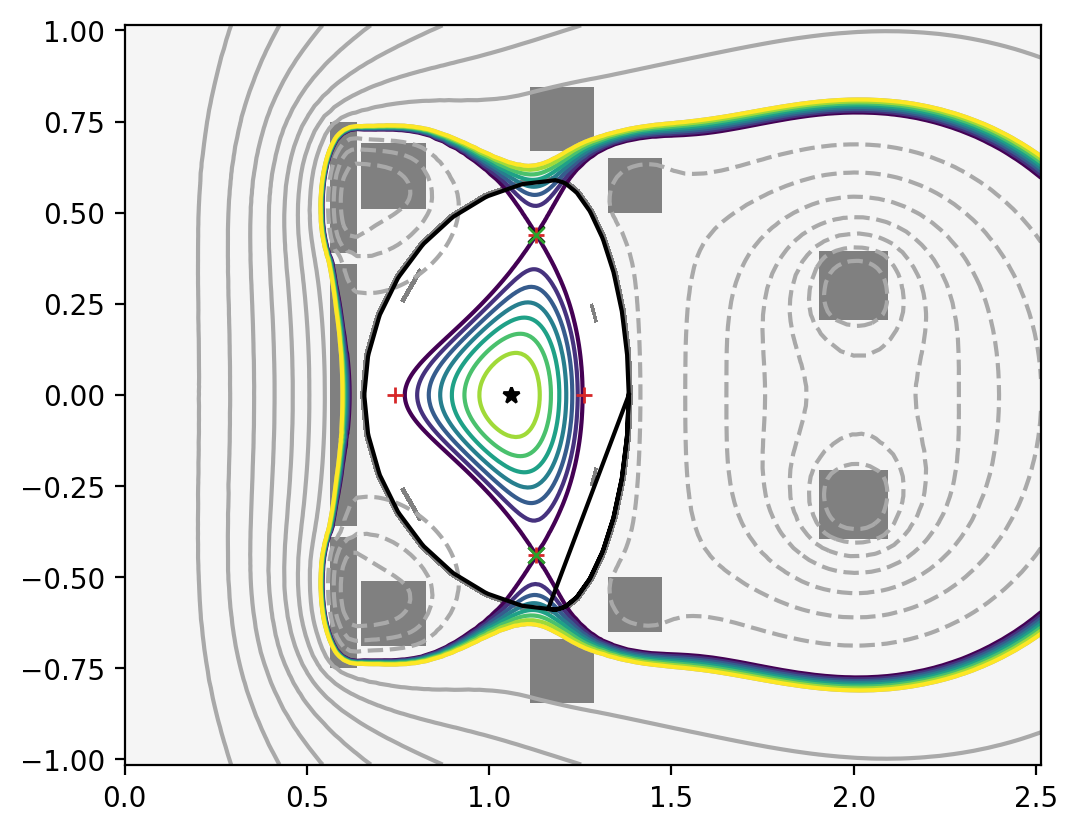

In [16]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [17]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  7.0961E+00  3.1930E+00  2.2932E-02  1.0534E+00 -1.7534E-05 -0.0000E+00
     2  6.5960E+00  3.0530E+00  3.5832E-03  1.0487E+00 -5.8751E-05 -0.0000E+00
     3  6.3933E+00  2.9886E+00  9.1846E-04  1.0462E+00 -5.2431E-05 -0.0000E+00
     4  6.3058E+00  2.9601E+00  5.9788E-04  1.0449E+00 -4.8336E-05 -0.0000E+00
     5  6.2673E+00  2.9473E+00  3.3085E-04  1.0443E+00 -4.6503E-05 -0.0000E+00
     6  6.2504E+00  2.9417E+00  1.6399E-04  1.0440E+00 -4.5837E-05 -0.0000E+00
     7  6.2431E+00  2.9392E+00  7.6859E-05  1.0439E+00 -4.5636E-05 -0.0000E+00
     8  6.2399E+00  2.9381E+00  3.4835E-05  1.0438E+00 -4.5597E-05 -0.0000E+00
     9  6.2385E+00  2.9377E+00  1.5424E-05  1.0438E+00 -4.5606E-05 -0.0000E+00
    10  6.2380E+00  2.9375E+00  6.7062E-06  1.0438E+00 -4.5624E-05 -0.0000E+00
    11  6.2377E+00  2.9374E+00  2.8712E-06  1.0438E+00 -4.5639E-05 -0.0000E+00
    12  6.2376E+00  2.9374E+00  1.2125E-06  1.0438E+00 -4.5649E-05 -0.0000E+00
    13  6.2376E+00  2.

0

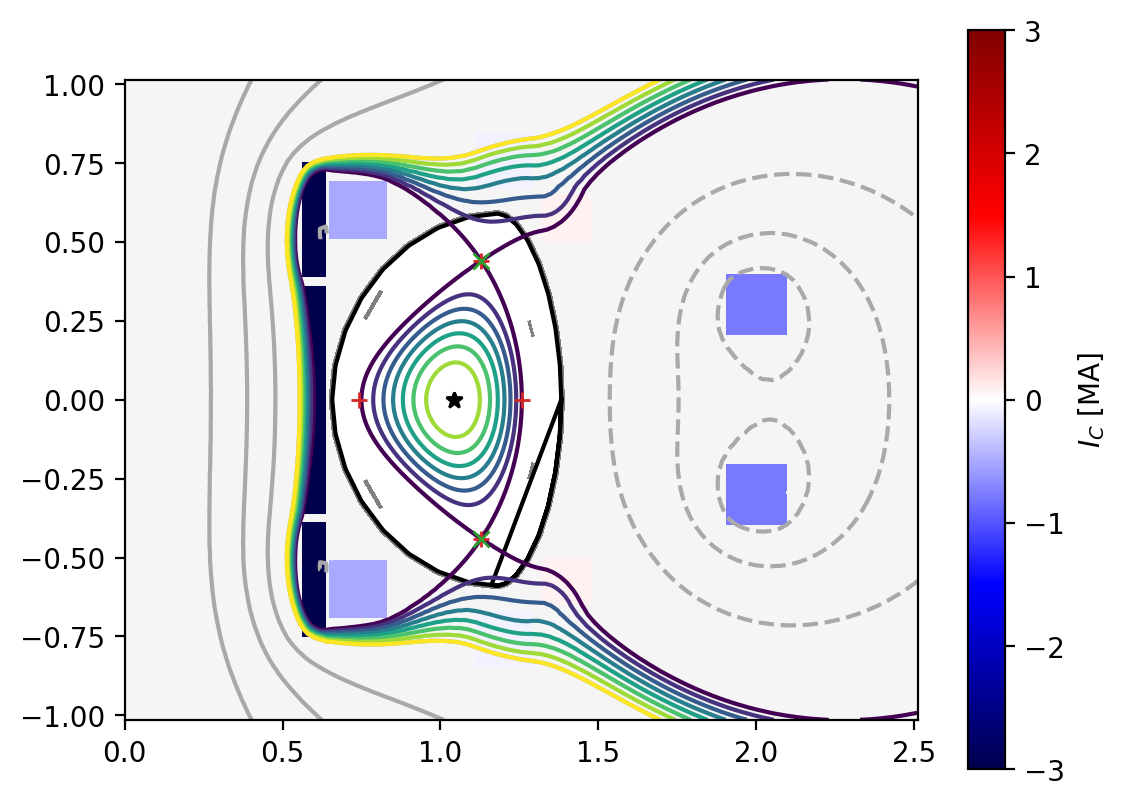

In [18]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)




Starting CG solver
     0  0.000000E+00  0.000000E+00  2.849344E+00
     1 -1.336181E+05  1.101472E+05  6.603982E-01  5.995597E-06
     2 -1.387020E+05  1.173654E+05  3.164909E-01  2.696628E-06
     3 -1.396517E+05  1.191189E+05  1.054907E-01  8.855924E-07
     4 -1.397199E+05  1.194750E+05  4.579933E-02  3.833384E-07
     5 -1.397302E+05  1.193413E+05  1.760405E-02  1.475102E-07
     6 -1.397315E+05  1.193355E+05  7.182523E-03  6.018765E-08
     7 -1.397317E+05  1.193304E+05  2.576296E-03  2.158960E-08
     8 -1.397318E+05  1.193321E+05  9.064206E-04  7.595781E-09
     9 -1.397318E+05  1.193323E+05  3.988465E-04  3.342318E-09
    10 -1.397318E+05  1.193325E+05  1.700606E-04  1.425099E-09
    20 -1.397318E+05  1.193325E+05  1.121537E-08  9.398423E-14
Growth rate = 4.5020E+02 [s^-1]
Growth time = 2.2212E-03 [s]


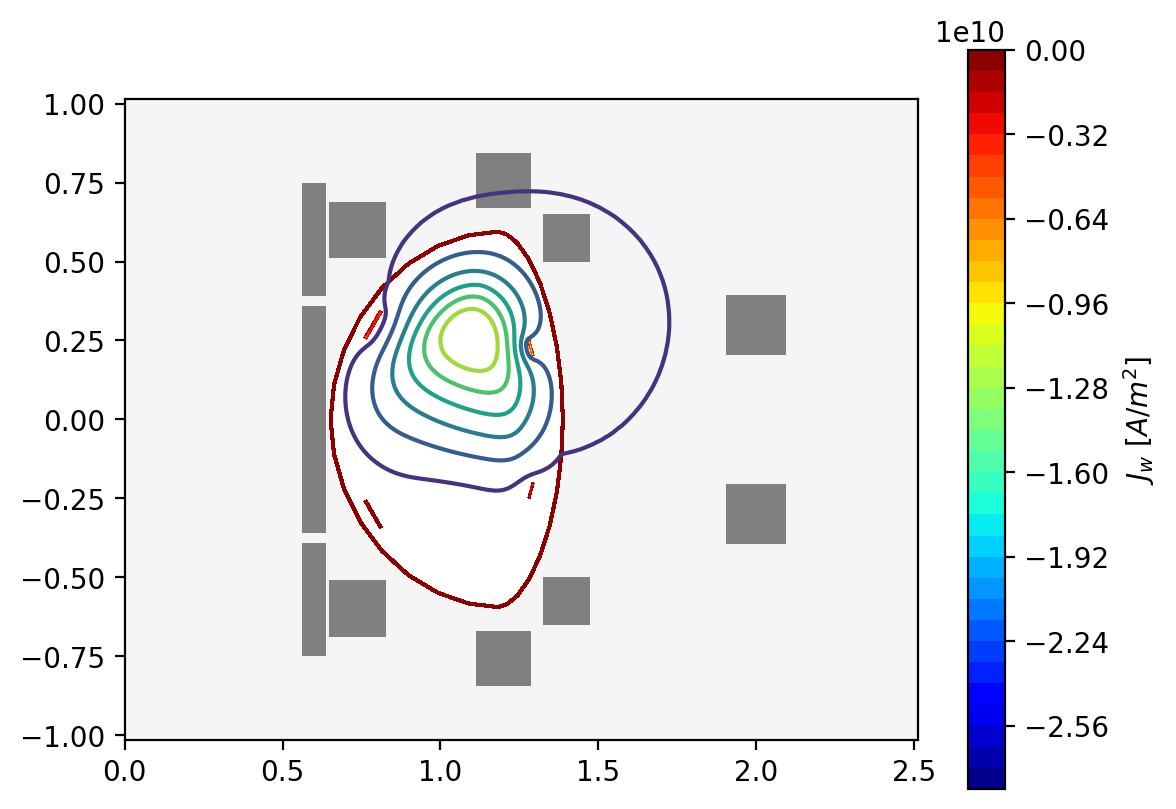

In [19]:
eig_vals, eig_vecs = mygs.eig_td(-5.E3,10,True) 
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,-eig_vecs[0,:]*eig_vals[0,0])
print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))

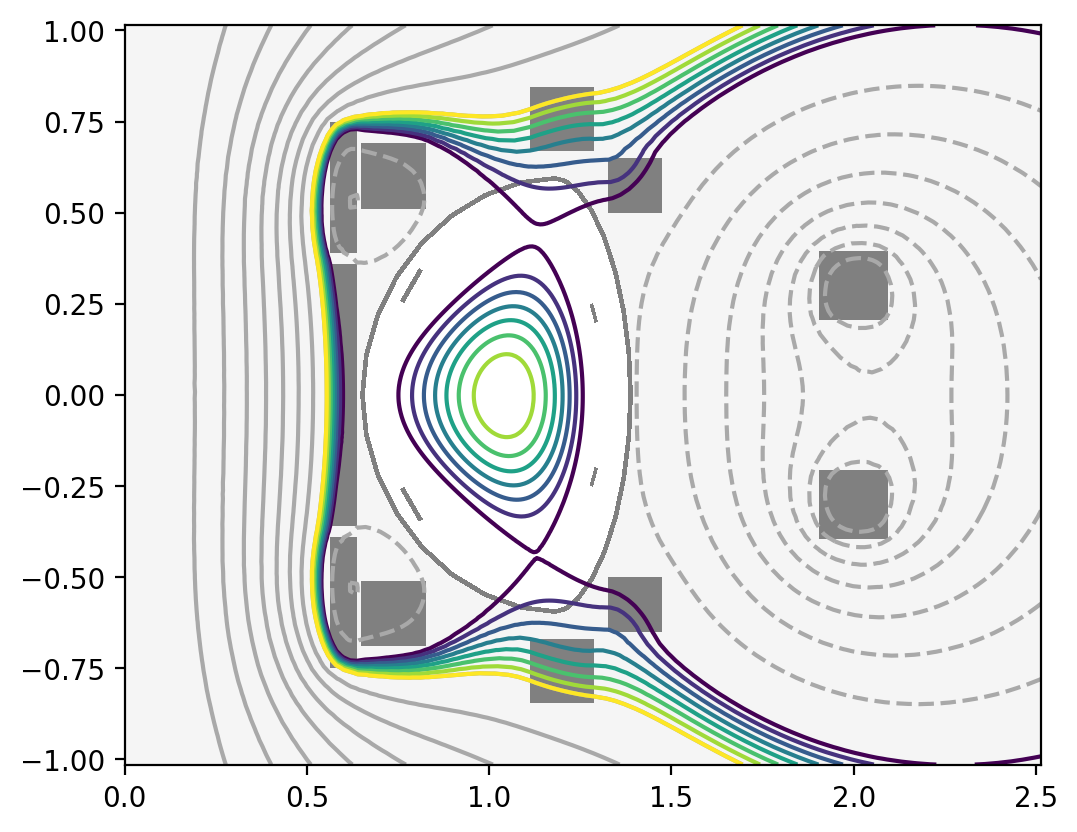

In [20]:
psi0 = mygs.get_psi(normalized = False)
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0-eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]/50

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,(psi_ic-mygs.psi_bounds[1])/(mygs.psi_bounds[0]-mygs.psi_bounds[1]),xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)

In [21]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_targets(Ip=0.75E6,Ip_ratio=1)
mygs.setup_td(1.E-03,1.E-13,1.E-11,pre_plasma=False)

In [22]:
import time
sim_time = 0.0
dt = 1.E-1/-eig_vals[0,0]
nplot = 1
nstatus = 1
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()
q_95 = []
gammas = []

for i in range(56):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    q_prof = mygs.get_q()
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
        psi,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi = 0.95)
        eig_vals, eig_vecs = mygs.eig_td(-5.E3,3,True) 
        gammas.append(-eig_vals[0,0])
        q_95.append(qvals[0])
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

2.22122E-04 2.22122E-04    2   17    0.334    0
4.44244E-04 2.22122E-04    2   14    0.183    0
6.66366E-04 2.22122E-04    2   14    0.182    0
8.88488E-04 2.22122E-04    2   14    0.183    0
1.11061E-03 2.22122E-04    2   15    0.194    0
1.33273E-03 2.22122E-04    2   15    0.192    0
1.55485E-03 2.22122E-04    2   15    0.192    0
1.77698E-03 2.22122E-04    2   16    0.202    0
1.99910E-03 2.22122E-04    2   15    0.192    0
2.22122E-03 2.22122E-04    2   16    0.201    0
2.44334E-03 2.22122E-04    2   15    0.194    0
2.66546E-03 2.22122E-04    2   15    0.192    0
2.88758E-03 2.22122E-04    2   15    0.191    0
3.10971E-03 2.22122E-04    2   16    0.200    0
3.33183E-03 2.22122E-04    2   16    0.201    0
3.55395E-03 2.22122E-04    2   15    0.190    0
3.77607E-03 2.22122E-04    2   16    0.199    0
3.99819E-03 2.22122E-04    2   16    0.200    0
4.22032E-03 2.22122E-04    2   16    0.199    0
4.44244E-03 2.22122E-04    2   15    0.189    0
4.66456E-03 2.22122E-04    2   16    0.2

Text(0, 0.5, '$\\gamma$')

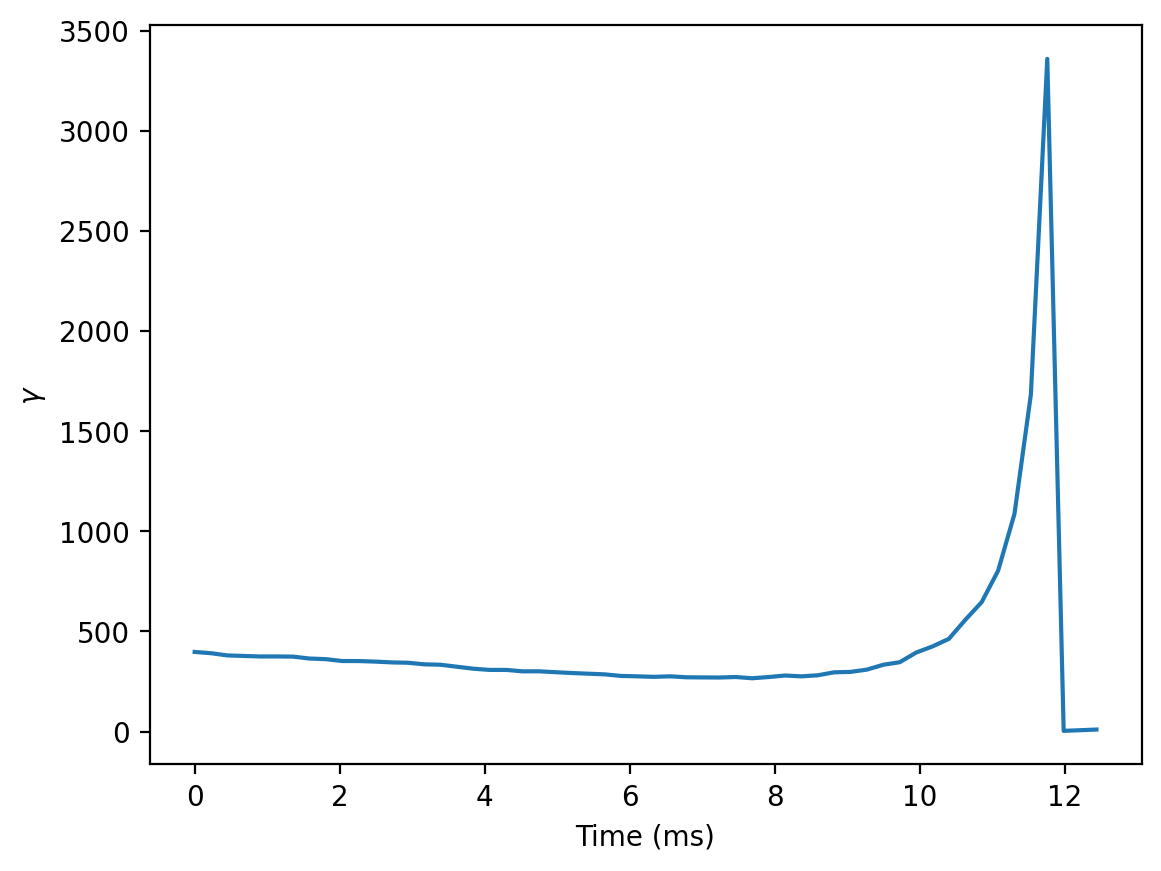

In [23]:
plt.plot(np.linspace(0,sim_time*1000, len(gammas)), gammas)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\gamma$')

Text(0, 0.5, 'Z (m)')

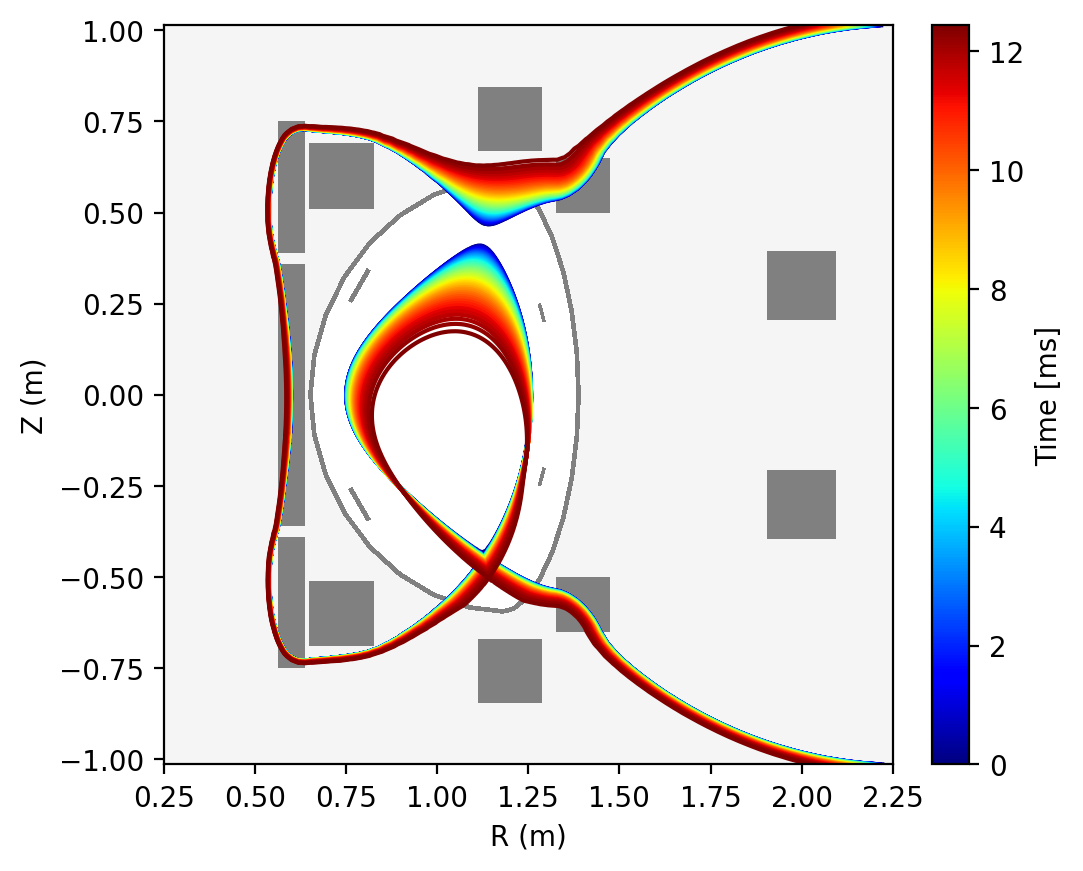

In [25]:
import matplotlib as mpl
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax, limiter_color = None)
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), ax = ax,label='Time [ms]',fraction=0.046, pad=0.04)
plt.xlim([0.25, 2.25])
plt.xlabel('R (m)')
plt.ylabel('Z (m)')